In [ ]:
!pip install transformers
!pip install pywaffle
!pip install emoji

In [ ]:
import pandas as pd
import pyarrow.parquet as pq
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
#import emoji
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
#from pywaffle import Waffle
import re
from textblob import TextBlob
#from transformers import BertTokenizer
from wordcloud import WordCloud

drive.mount('/content/drive/')
sns.set_theme()
plt.rcParams['figure.figsize'] = [7, 4]
pd.set_option('display.max_columns', None)

In [ ]:
#dataset_news = pq.read_table('/content/drive/MyDrive/DDE Final Project/dataset_news/dataset_news.snappy.parquet')
#dataset_news = dataset_news.to_pandas()

In [ ]:
dataset_UK = pq.read_table('/content/drive/MyDrive/DDE Final Project/dataset_UK/dataset.snappy.parquet')
dataset_UK = dataset_UK.to_pandas()

In [ ]:
(dataset_UK['retweetbody'].notnull()).value_counts(True)
#len(dataset_UK)

True     0.584605
False    0.415395
Name: retweetbody, dtype: float64

## Dataset Columns
|-- id: integer (nullable = false) (hashed id)

|-- verb: string (nullable = true) (can be post or share if a RT) |-- user: integer (nullable = false) (hashed user id)

|-- inreplyto: struct (nullable = true) (in reply to)

| |-- link: string (nullable = true)

|-- link: string (nullable = true)

|-- body: string (nullable = true) (body of tweet)

|-- retweetbody: string (nullable = true) (body of retweeted tweet) |-- date: string (nullable = true) (date)

|-- postedtime: string (nullable = true) (date and time)

|-- retweetcount: long (nullable = true) (number of RT)

|-- favoritescount: long (nullable = true) (number of likes)

|-- generator: string (nullable = true) (generator)

|-- twitter_lang: string (nullable = true) (language)

|-- year: string (nullable = true) (year)

|-- userLocation: string (nullable = true) (user location)

#  <font color=darkblue>🧹 **Data Cleaning**  🧹</font>


Date conversion to datetime and deafult on the first day of the month

We perform the *Data Cleaning* in the following way:

- Change to lowercase the tweets and authors' bio
- Switch *userVerified* from True/False to 0/1
- Transform the daily dates into months (2020-03-21 --> 2020-03-01)
- Extract only the relevant columns for our analysis

In [ ]:
dataset_UK['body'] = dataset_UK['body'].str.lower()
dataset_UK['retweetbody'] = dataset_UK['retweetbody'].str.lower()
dataset_UK['userBio'] = dataset_UK['userBio'].str.lower()

In [ ]:
dataset_UK.loc[dataset_UK['verb'] == 'share', 'body'] = dataset_UK.loc[dataset_UK['verb'] == 'share', 'retweetbody']
dataset_UK['userVerified'] = dataset_UK['userVerified'].astype(int)

In [ ]:
dataset_UK['date'] = pd.to_datetime(dataset_UK['date']).dt.to_period('M').dt.to_timestamp()

In [ ]:
dataset_final = dataset_UK[['verb', 'user', 'body', 'date', 'year', 'generator',
                            'retweetcount', 'favoritescount', 'userFriends',
                            'userFollowers', 'userNumTweets', 'userVerified',
                            'userBio', 'subregion']]

# <font color=darkblue>⚙️ **Feature Engineering**  ⚙️</font>

# Relevance Score for every tweet

We assign a **relevance score** for every post by defining the following rule:

- $+0$ if the account isn't verified and hasn't a relevant biography.
- $+0.5$ if the tweet has more than 10k retweets
- $+1$ if the account's bio is relevant (such as "professor" or "economist")
- $+1$ if the account has more than 30k followers
- $+2$ if the account is verified

In [ ]:
culture_people = [ 'professor', 'economist', 'phd', 'journal', 'financ', 'economic', 'lecturer',
                  'principal', 'ranked', 'analy', 'university']

dataset_final.loc[:, 'relevance_score'] = 0
dataset_final.loc[dataset_final['retweetcount'] > 10000, 'relevance_score'] += 0.5
dataset_final.loc[(dataset_final['userBio'].str.contains('|'.join(culture_people)) == True), 'relevance_score'] += 1
dataset_final.loc[dataset_final['userFollowers'] > 30000, 'relevance_score'] += 1
dataset_final.loc[(dataset_final['userVerified'] == 1), 'relevance_score'] += 2

In [ ]:
print('The amount of relevant tweets is:')
print(len(dataset_final[dataset_final['relevance_score'] >= 0.5]))

The amount of relevant tweets is:
105490


## Bots Removal

The bots removal is done following three criteria:

1. **Low-number generators:** rows containing tweets written by unusual generators are removed
2. **Declarate bots:** tweets containing generators with "bot" word in the name are deleted (example: Twitter healthcare bot)
3. **Bot-related words:** most-commonly bot used words, such as "free money" or "trading course" are considered bot-made

In [ ]:
#generators that posted only once
once_generators = list((dataset_UK.groupby('generator').count()['id'].sort_values(ascending = False))[((dataset_UK.groupby('generator').count()['id'].sort_values(ascending = False) <= 2) == True)].index)

#declarate bots
bot_generators = list(set(list([i for i in dataset_UK['generator'] if 'bot' in i.lower()])))

all_bots = set(once_generators + bot_generators)

#bot-related words
bot_tokens = ['free money', 'trading course', 'deposit', 'save up', 'special discount',
              'for free', 'buy now', 'ecommerce', 'e-commerce', 'amazon stock', 'porn',
              'masturb', 'sex', 'gift']

dataset_bots = dataset_final.loc[(dataset_final['body'].str.contains('|'.join(bot_tokens)) == True) & (dataset_final['relevance_score'] == 0) |
                  (dataset_final['generator'].str.contains('|'.join(all_bots)))]#['body'][30]

dataset_final = dataset_final.drop(list(dataset_bots.index))

<ipython-input-13-709260287474>:15: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  (dataset_final['generator'].str.contains('|'.join(all_bots)))]#['body'][30]


In [ ]:
print('The total amount of bots found is:')
print(len(dataset_bots))

The total amount of bots found is:
12700


## Tags Removal

We then remove the tags in the tweets body, that may be annoying for our NLP analysis, such as "@ElonMusk".

In [ ]:
dataset_final.loc[:, 'body'] = dataset_final.loc[:, 'body'].str.replace(r'\B@\w+', '', regex=True)

## Website Removal
At the end of every tweet, we find the respective link that is annoying for analyzing the text. We remove it

In [ ]:
dataset_final.loc[:, 'body'] = dataset_final.loc[:, 'body'].str.split('https').str[0]

## Tweets Cleaning

In [ ]:
def emoji_removal(text):
  text = emoji.demojize(text, delimiters=(" ", " "))
  return text

dataset_final['body'] = dataset_final['body'].apply(emoji_removal)


In [ ]:
#dataset_final.to_csv('dataset_finale.csv', sep = '|')

# <font color=darkblue>➕ **Features Adding**  ➕</font>


## Named Entity Recognition - Percentage features <font color=red> [*Failed*]  </font>


Given that we are interested in forecasting the percentages of inflation, we will add the *percentage feature* that is obtained by extracting all the cited percentages in the tweet

In [ ]:
import spacy
from spacy import displacy

nlp_lg = spacy.load('en_core_web_sm')

def percentage_extraction(text):
  doc = nlp_lg(text)
  percentage_s = [t.text for t in doc.ents if t.label_ == 'PERCENT']
  return percentage_s

In [ ]:
dataset_important = dataset_final[dataset_final['relevance_score']>= 0.5]

In [ ]:
dataset_important = dataset_important.sort_values('date')#.to_csv('dataset_elaborato.csv')

In [ ]:
percentuali = dataset_important['body'][100:150].apply(percentage_extraction)

In [ ]:
def extract_float_from_list(lst):
    numbers = [re.findall(r"[-+]?\d*\.\d+|\d+", val) for val in lst]
    numbers = [float(num[0]) if len(num) > 0 else None for num in numbers]
    return numbers

numbers = percentuali.apply(extract_float_from_list)
numbers = numbers.replace([], 3)

#numbers = numbers[numbers.apply(lambda x: len(x) > 0)]

#numbers = pd.Series([num for sublist in numbers for num in sublist])


In [ ]:
lista = []
for i in percentuali.str[0]:
  try:
    lista.append(i.text)
  except:
    lista.append(i)

In [ ]:
lista_nuova = []
for i in lista:
  try:
    lista_nuova.append(i.replace('%', '').replace('percent', ''))
  except:
    lista_nuova.append(i)


In [ ]:
dataset_final['percentages_cited'] = dataset_final['body'].apply(percentage_extraction)

#  <font color=darkblue>🔎 **Exploratory Data Analysis**  🔎</font>

In [ ]:
dataset_final.head(3)

,verb,user,body,date,year,generator,retweetcount,favoritescount,userFriends,userFollowers,userNumTweets,userVerified,userBio,subregion,relevance_score
0,post,-931661990,after successfully making iftar for your whole...,2018-05-01,2018,Twitter for iPhone,0,0,145,232,9408,0,sabr,Greater London,0.0
1,share,1115606588,if you still think this is an acceptable price...,2018-05-01,2018,Twitter for iPhone,87,0,402,123,5952,0,None,Essex,0.0
2,share,-59887667,this is good news. our armed forces in line fo...,2018-05-01,2018,Twitter Web Client,231,0,207,1478,108401,0,do not dwell on the past or dream of the futur...,None,0.0


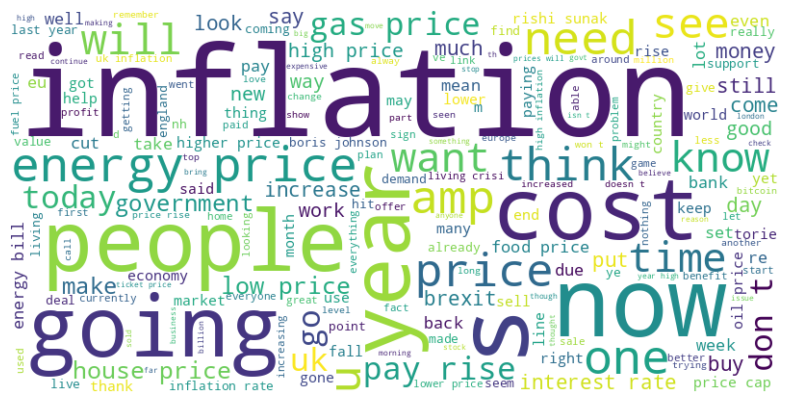

In [ ]:
parole = ' '.join(dataset_final["body"].astype(str))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(parole)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

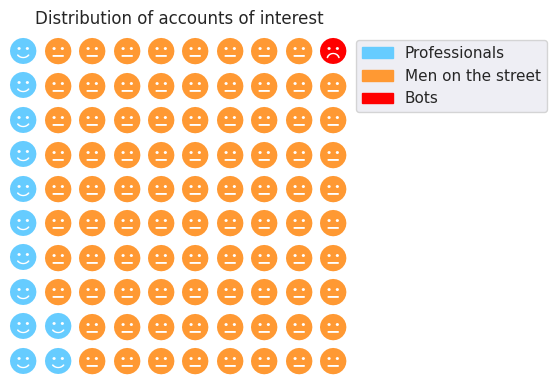

In [ ]:
perc_culture =  len(dataset_final[dataset_final['relevance_score'] >= 1])/ len(dataset_final)
perc_noculture = 1 - perc_culture

#percentages of accounts of interest
value = {'Professionals': 12, 'Men on the street': 87, 'Bots': 1}

# Waffle chart
plt.figure(
    FigureClass = Waffle,
    rows = 10,
    columns = 10,
    values = value,
    colors = ["#66CCFF", "#FF9933", 'red'],
    icons = ["face-smile", "face-meh", 'face-frown'],
    legend = {'loc': 'upper left', 'bbox_to_anchor': (1, 1)})

plt.title('Distribution of accounts of interest')
plt.show()

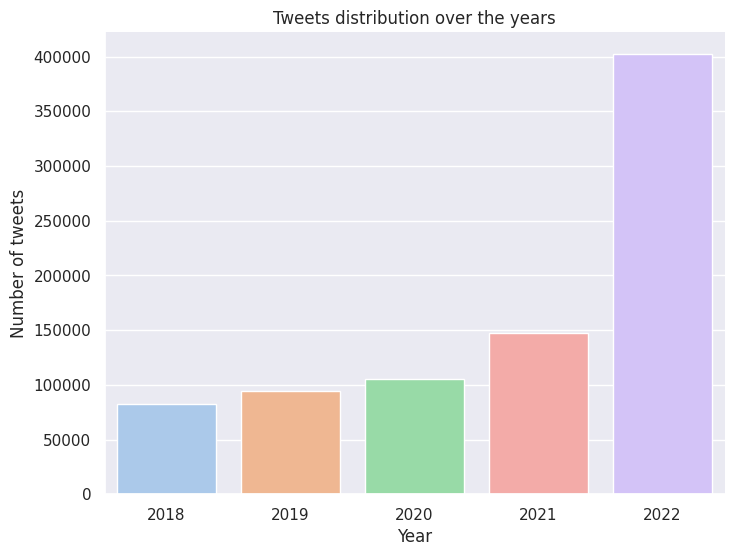

In [ ]:
years_distr = dataset_final['year'].value_counts()


plt.rcParams['figure.figsize'] = [8,6]
sns.barplot(data=years_distr, x=years_distr.index, y=years_distr.values, palette="pastel", orient='v').set(title='Tweets distribution over the years')
sns.despine()
plt.ylabel("Number of tweets")
plt.xlabel("Year")
plt.xticks([0, 1, 2, 3, 4], ['2018', '2019', '2020', '2021', '2022'])
plt.show()

In [ ]:
plt.rcParams['figure.figsize'] = [7, 4]
#plt.pie(dataset_final['subregion'])
plt.show()

dataset_final['subregion'].value_counts()[:20]

Greater London                    203463
City and Borough of Manchester     20798
Essex                              18052
Glasgow City                       14295
City and Borough of Liverpool      12075
City of Edinburgh                  10766
Leicestershire                      9419
City of Bristol                     8239
City and Borough of Leeds           7708
City and Borough of Birmingham      7654
West Sussex                         7468
Borough of Sandwell                 7230
Oxfordshire                         7181
Hampshire                           6908
Cambridgeshire                      6571
Lancashire                          6451
City and Borough of Sheffield       6304
Kent                                5297
Borough of Brighton and Hove        5259
City of Nottingham                  5221
Name: subregion, dtype: int64

## Target dataset

In [ ]:
dataset_target = pd.read_csv('/content/drive/MyDrive/DDE Final Project/target_inflation_UK.csv', sep = ',')#.melt()
dataset_target.rename(columns={"CPALTT01GBM659N": "value", "DATE": "date"}, inplace=True)
dataset_target['date'] = pd.to_datetime(dataset_target['date'])
dataset_target = dataset_target.loc[4:,:]

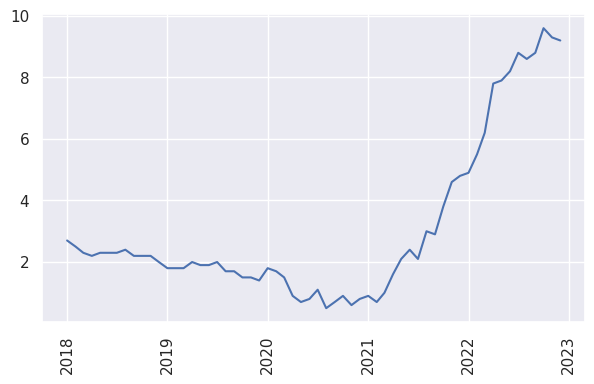

In [ ]:
plt.rcParams['figure.figsize'] = [7, 4]
plt.plot(dataset_target['date'],
         dataset_target['value'])
plt.xticks(rotation=90)


plt.show()

# Sentiment Analysis

## finBERT

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification

finbert = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-tone',num_labels=3)
tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-tone')

In [ ]:
labels = {0:'neutral',
          1:'positive',
          2:'negative'
          }

In [ ]:
dataset_important = dataset_final[dataset_final['relevance_score']>= 0.5]

In [ ]:
dataset_important = dataset_important.sort_values('date')#.to_csv('dataset_elaborato.csv')

In [ ]:
X = dataset_important['body'].to_list()
X = [str(i) for i in X]

In [ ]:
sent_val = list()
for x in X:
    inputs = tokenizer(x, return_tensors="pt", padding=True)
    outputs = finbert(**inputs)[0]

    val = labels[np.argmax(outputs.detach().numpy())]

    sent_val.append(val)

## TextBlob

We can use TextBlob to get and then analyze the sentiment of each tweet in our dataset

In [ ]:
def tb_score(tweet):
    analysis = TextBlob(tweet)
    return analysis.sentiment.polarity

dataset_final['TB_Sentiment'] = dataset_final['body'].apply(tb_score)

The 'tb_score(tweet)' function that we have defined takes a tweet as input and returns its sentiment polarity. The polarity score ranges from -1 to 1, where -1 represents a negative sentiment, 0 is neutral, and 1 indicates a positive sentiment.

We can now categorize the sentiment, based on a specific threshold

In [ ]:
def categ_tb_sentiment(score):
    if score > 0:
        return 'Positive'
    elif score < 0:
        return 'Negative'
    else:
        return 'Neutral'

dataset_final['TB_SentimentCategory'] = dataset_final['TB_Sentiment'].apply(categ_tb_sentiment)

### Sentiment distribution

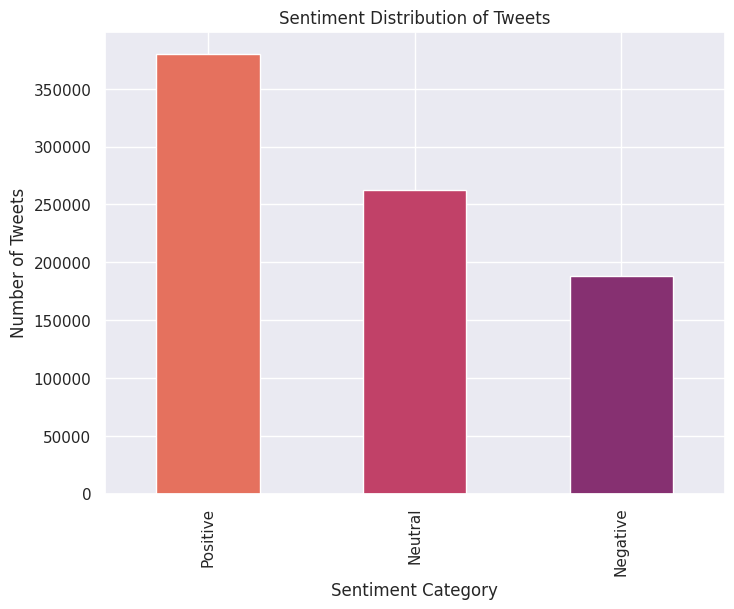

In [ ]:
plt.figure(figsize=(8, 6))
sent_counts = dataset_final['TB_SentimentCategory'].value_counts()
num_bars = len(sent_counts)
colors = sns.color_palette("flare", n_colors=num_bars)
sent_counts.plot(kind='bar', color=colors)
plt.title('Sentiment Distribution of Tweets')
plt.xlabel('Sentiment Category')
plt.ylabel('Number of Tweets')
plt.show()

As we can see from the plot, the sentiment distribution is mostly positive

## Vader

In [ ]:
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')

In [ ]:
# Initialize the SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

# Define a function to get the sentiment score for each tweet
def vader_score(tweet):
    sentiment_score = analyzer.polarity_scores(tweet)
    return sentiment_score['compound']  # The 'compound' score represents the overall sentiment

# Apply the function to get the sentiment score for each tweet
dataset_final['VaderSentiment'] = dataset_final['body'].apply(vader_score)

# Categorize the sentiment based on the compound score
def categ_v_sentiment(score):
    if score >= 0.05:
        return 'Positive'
    elif score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

dataset_final['Vader_SentimentCategory'] = dataset_final['VaderSentiment'].apply(categ_v_sentiment)


### Sentiment Distribution

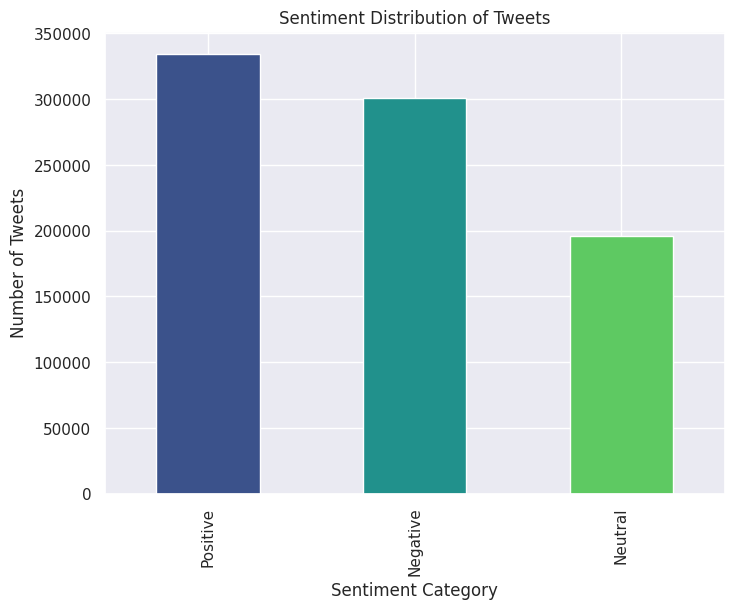

In [ ]:
plt.figure(figsize=(8, 6))
sent_counts = dataset_final['Vader_SentimentCategory'].value_counts()
num_bars = len(sent_counts)
colors = sns.color_palette("viridis", n_colors=num_bars)
sent_counts.plot(kind='bar', color=colors)
plt.title('Sentiment Distribution of Tweets')
plt.xlabel('Sentiment Category')
plt.ylabel('Number of Tweets')
plt.show()

The results show that the sentiment mostly positive, corresponding with what we found with TextBlob

## Word2Vec

In [ ]:
pip install gensim

In [ ]:
import gensim.downloader as api

In [ ]:
model = api.load("word2vec-google-news-300")

In [ ]:
def get_w2v_sentiment(tweet):
    words = tweet.split()
    sentiment_score = 0

    for word in words:
        if word in model:
            sentiment_score += model.similarity('good', word) - model.similarity('bad', word)

    return sentiment_score / len(words)

dataset_final['W2V_Sentiment'] = dataset_final['body'].apply(get_w2v_sentiment)


In [ ]:
def categ_w2v_sentiment(score):
    if score > 0:
        return 'Positive'
    elif score < 0:
        return 'Negative'
    else:
        return 'Neutral'

dataset_final['W2V_SentimentCategory'] = dataset_final['W2V_Sentiment'].apply(categ_w2v_sentiment)


### Sentiment distribution

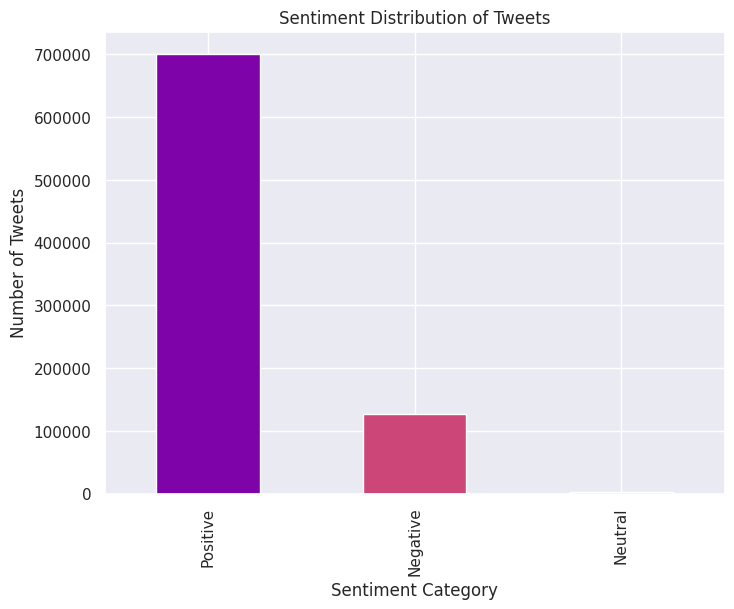

In [ ]:
plt.figure(figsize=(8, 6))
sent_counts = dataset_final['W2V_SentimentCategory'].value_counts()
num_bars = len(sent_counts)
colors = sns.color_palette("plasma", n_colors=num_bars)
sent_counts.plot(kind='bar', color=colors)
plt.title('Sentiment Distribution of Tweets')
plt.xlabel('Sentiment Category')
plt.ylabel('Number of Tweets')
plt.show()

Also here, the sentiment is mostly positive, so it keeps being coherent with the results from the previous metrics

### "Visual correlation"

Now we observe if a sort of relationship between sentiment and inflation is visible

In [ ]:
#re-upload the data

dataset = pd.read_csv('/content/drive/MyDrive/DDE Final Project/dataset_finale.csv',
                      sep = '|',
                      lineterminator='\n')

In [ ]:
denom = dataset.groupby('date').count()['user']

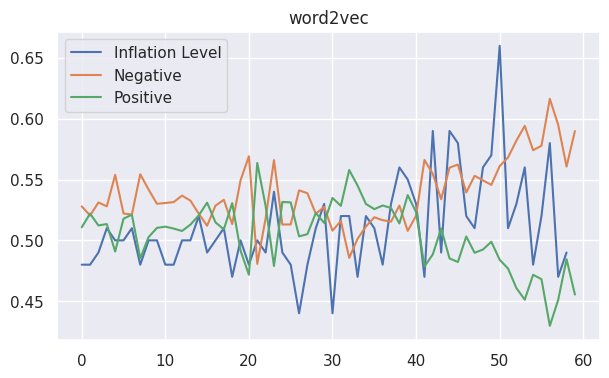

In [ ]:
xx = []
for i in dataset_target['value'].index-1:
    try:
        xx.append(dataset_target['value'][i+1] - dataset_target['value'][i])
    except:
        continue

plt.plot(np.array(xx)/10 + 0.5)

#plt.plot(np.array(dataset[dataset['W2V_SentimentCategory'] == 'Neutral'].groupby('date').count()['verb'] / denom))
plt.plot(np.array(dataset[dataset['W2V_SentimentCategory'] == 'Negative'].groupby('date').count()['verb'] / denom) + 0.4)
plt.plot(np.array(dataset[dataset['W2V_SentimentCategory'] == 'Positive'].groupby('date').count()['verb'] / denom) - 0.35)

plt.title('word2vec')
plt.legend(['Inflation Level', 'Negative', 'Positive'])
plt.show()

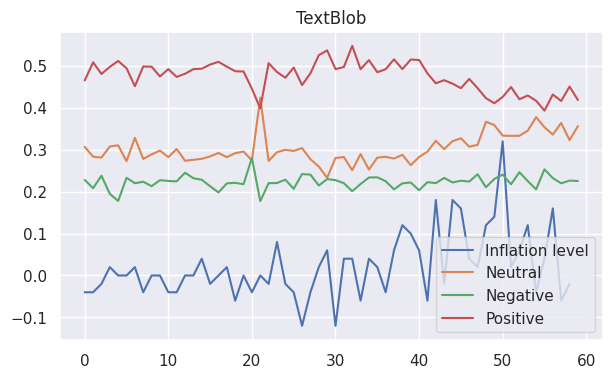

In [ ]:
plt.plot(np.array(xx)/5)

plt.plot(list(dataset[dataset['TB_SentimentCategory'] == 'Neutral'].groupby('date').count()['verb'] / denom))
plt.plot(list(dataset[dataset['TB_SentimentCategory'] == 'Negative'].groupby('date').count()['verb'] / denom))
plt.plot(list(dataset[dataset['TB_SentimentCategory'] == 'Positive'].groupby('date').count()['verb'] / denom))

plt.title('TextBlob')
plt.legend(['Inflation level', 'Neutral', 'Negative', 'Positive'])
plt.show()

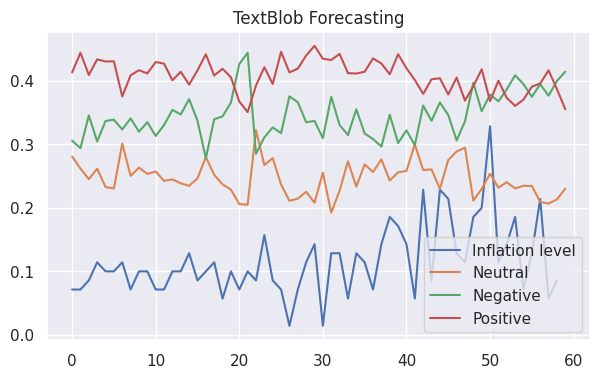

In [ ]:
plt.plot(np.array(xx[:])/7 + 0.1)

plt.plot(list(dataset[dataset['Vader_SentimentCategory'] == 'Neutral'].groupby('date').count()['verb'] / denom))
plt.plot(list(dataset[dataset['Vader_SentimentCategory'] == 'Negative'].groupby('date').count()['verb'] / denom))
plt.plot(list(dataset[dataset['Vader_SentimentCategory'] == 'Positive'].groupby('date').count()['verb'] / denom))

plt.title('TextBlob Forecasting')
#plt.legend(['Inflation Level', 'Negative Sentiment'])
plt.legend(['Inflation level', 'Neutral', 'Negative', 'Positive'])
plt.show()

### Correlation Analysis

In the case of TextBlob, a lagged-correlation is visible

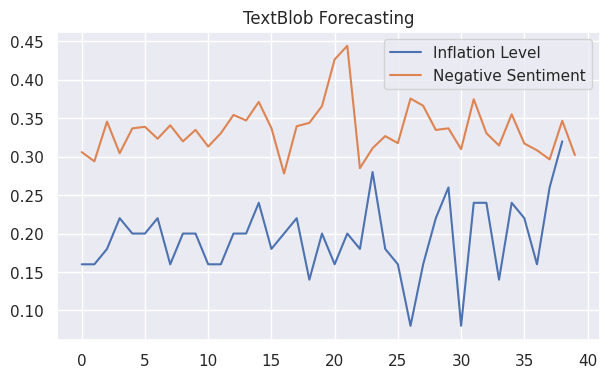

In [ ]:
plt.plot(np.array(xx[:-20])/5 + 0.2)

plt.plot(list(dataset[dataset['Vader_SentimentCategory'] == 'Negative'].groupby('date').count()['verb'] / denom)[:-20])

plt.title('TextBlob Forecasting')
plt.legend(['Inflation Level', 'Negative Sentiment'])
plt.show()

In [ ]:

x = np.array(xx[:-20])/5
y = np.array(dataset[dataset['Vader_SentimentCategory'] == 'Negative'].groupby('date').count()['verb'] / denom)[1:-20]

import statsmodels.api as sm
np.set_printoptions(suppress = True)
#calculate cross correlation

lag = list(sm.tsa.stattools.ccf(x, y, adjusted=False)).index(max(sm.tsa.stattools.ccf(x, y, adjusted=False)))
correlation = max(sm.tsa.stattools.ccf(x, y, adjusted=False))*100
print(f"With a lag of {lag}, we find a correlation of {correlation}%")


With a lag of 18, we find a correlation of 44.46042609593438%


In [ ]:
dataset = pd.read_csv('/content/drive/MyDrive/DDE Final Project/dataset_finale.csv',
                      sep = '|',
                      lineterminator='\n')

dataset = dataset.sort_values('date')

In [ ]:
dataset['date'] = pd.to_datetime(dataset['date']).dt.to_period('M').dt.to_timestamp()

dataset = dataset.merge(dataset_target, on = 'date')
dataset.rename(columns={"value": "Y"}, inplace=True)

# Forecasting

## Forecasting with XGBoost model

In [ ]:
from xgboost import XGBRegressor
xgb = XGBRegressor()

In [ ]:
train = dataset[(dataset["date"].dt.year <= 2021)]
test = dataset[(dataset["date"].dt.year == 2022)]

In [ ]:
columns = ['retweetcount', 'favoritescount', 'userFriends', 'userFollowers',
 'userNumTweets', 'userVerified', 'relevance_score', 'TB_Sentiment', 'VaderSentiment', 'W2V_Sentiment']

In [ ]:
# We first process the Vader Index and inflation
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
y_train = scaler.fit_transform(train['Y'].values.reshape(-1, 1))

# Then we preprocess the Vader Index for testing data
y_test = scaler.fit_transform(test['Y'].values.reshape(-1, 1))

In [ ]:
xgb.fit(train[columns], y_train)

In [ ]:
import tensorflow as tf

In [ ]:
def evaluate_preds(y_true, y_pred):
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)


  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)

  return {"mae": np.mean(mae.numpy()),
          "mse": np.mean(mse.numpy()),
          "rmse": np.mean(rmse.numpy())}

In [ ]:
predictions_vader = xgb.predict(test[columns])
results_vader = evaluate_preds(y_true=tf.squeeze(y_test), y_pred=tf.squeeze(predictions_vader))
results_vader

{'mae': 0.39366567, 'mse': 0.18098529, 'rmse': 0.42542365}

## Forecasting with ARIMA(0,1,0)

In [ ]:
!pip install statsmodels
!pip install pmdarima

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.stattools import adfuller
import itertools
from numpy import log
import itertools
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import math

In order to proceed with the ARIMA model, we created a new dataset, keeping the column with the date and the one with the monthly inflation level, adding then three new indexes: TextBlob Index, Vader Index and Word2Vec Index. We calculated them by doing the mean of the respective sentiment score for each first day of each month. We then have done a groupby on the date.

This will result in the following dataset:

In [ ]:
#Upload new dataset

final_df = pd.read_csv('/content/drive/MyDrive/DDE Final Project/df_final.csv', sep='|', engine='python')
final_df.tail()

,date,index_textblob,index_vader,index_word2vec,Y
55,2022-08-01,0.042968,-0.003319,0.011453,8.6
56,2022-09-01,0.049805,-0.007047,0.011295,8.8
57,2022-10-01,0.049503,0.018556,0.011864,9.6
58,2022-11-01,0.056886,-0.002690,0.012272,9.3
59,2022-12-01,0.048536,-0.018235,0.012317,9.2


In [ ]:
columns = ['index_textblob', 'index_vader', 'index_word2vec']

We perform the forecasting exercise using all the available years, with a window = 12.

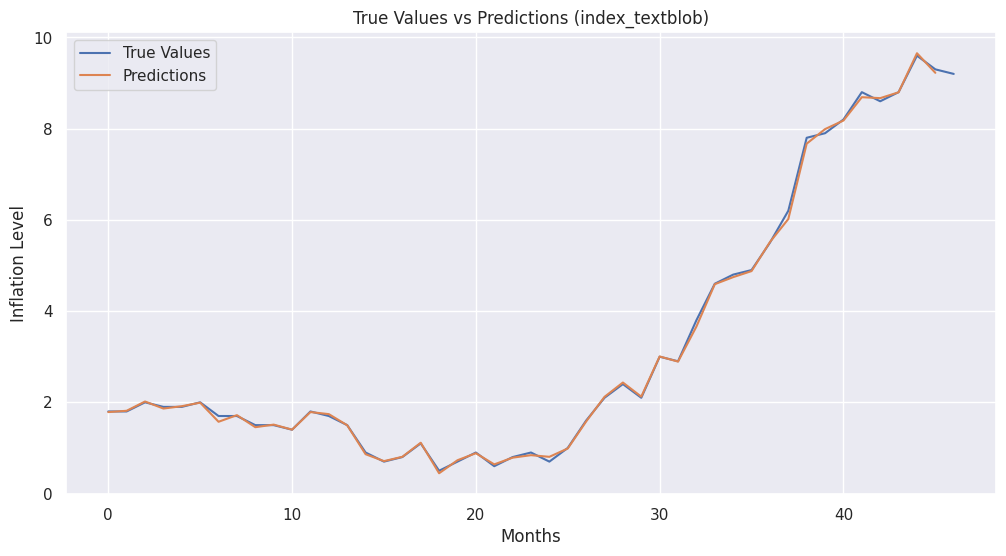

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


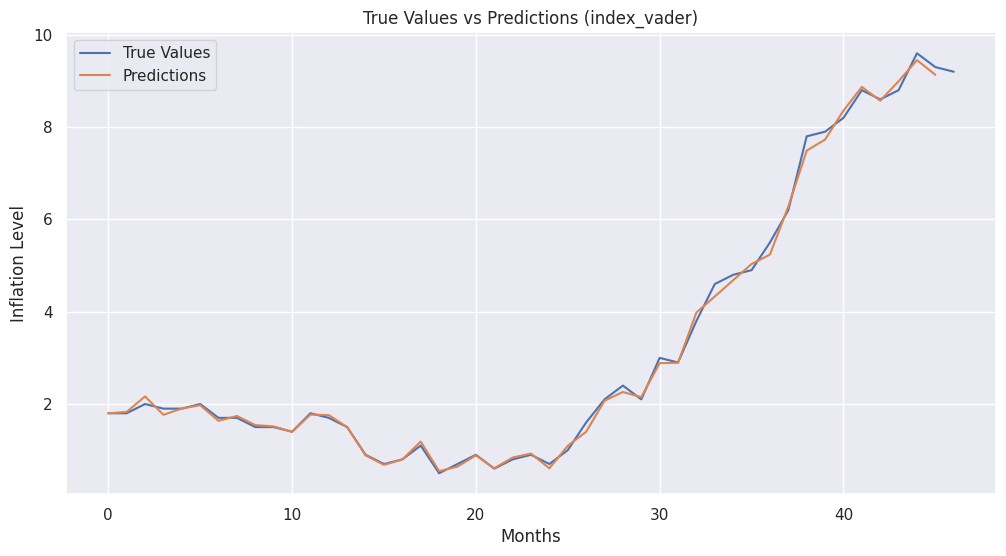

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


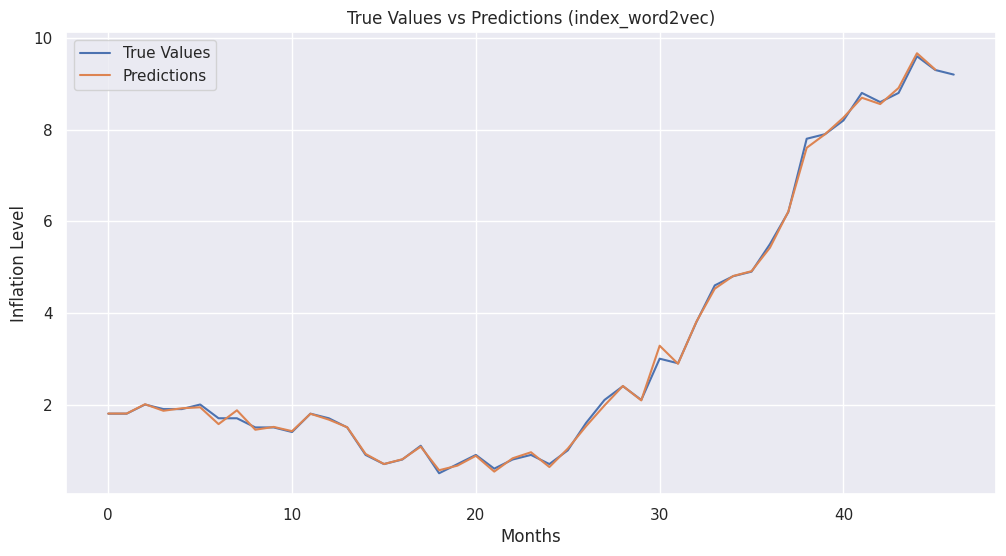

In [ ]:
columns = ['index_textblob', 'index_vader', 'index_word2vec']
window_size = 12

mae_dict = {}
mse_dict = {}

for column in columns:
    predictions = []

    for i in range(len(final_df) - window_size):
        train_df = final_df[i:i+window_size]
        test_df = final_df[i+window_size:i+window_size+1]

        train_X = train_df[column].values.reshape(-1, 1)
        train_Y = train_df['Y'].values
        test_X = test_df[column].values.reshape(-1, 1)

        model = ARIMA(train_Y, order=(0, 1, 0), exog=train_X)
        model_fit = model.fit()

        forecast = model_fit.forecast(steps=1, exog=test_X)
        predicted_value = forecast[0]
        predictions.append(predicted_value)

    true_values = final_df['Y'].values[window_size:]
    mae = mean_absolute_error(true_values[:-1], predictions[1:])
    mse = mean_squared_error(true_values[:-1], predictions[1:])

    mae_dict[column] = mae
    mse_dict[column] = mse

    plt.rcParams['figure.figsize'] = [12, 6]
    plt.plot(true_values[1:], label='True Values')
    plt.plot(predictions[2:], label='Predictions')
    plt.xlabel('Months')
    plt.ylabel('Inflation Level')
    plt.title(f'True Values vs Predictions ({column})')
    plt.legend()
    plt.show()

As we can see from the plot, the predicted values are really close to the real ones

In [ ]:
mae_dict

{'index_textblob': 0.04097896544267722,
 'index_vader': 0.08380289954494963,
 'index_word2vec': 0.047781658410657256}

In [ ]:
mse_dict

{'index_textblob': 0.0034141629803499177,
 'index_vader': 0.013251573837809043,
 'index_word2vec': 0.005517200791533652}

In [ ]:
#RMSE

rmse_textblob = math.sqrt(0.0034141629803541382)
rmse_vader = math.sqrt(0.013251573838029714)
rmse_w2v = math.sqrt(0.005517200791534025)

print(rmse_textblob, rmse_vader, rmse_w2v)

0.058430839291885396 0.11511548044476778 0.07427786205548746


## Forecasting with Spacy

In [ ]:
output_dir = f"/content/data-data"
max_length = 2048

In [ ]:
dataset_target = pd.read_csv('/content/drive/MyDrive/DDE Final Project/target_inflation_UK.csv', sep = ',')#.melt()
dataset_target.rename(columns={"CPALTT01GBM659N": "value", "DATE": "date"}, inplace=True)
dataset_target['date'] = pd.to_datetime(dataset_target['date'])
dataset_target = dataset_target.loc[4:,:]

dataset = pd.read_csv('/content/drive/MyDrive/DDE Final Project/dataset_finale.csv',
                      sep = '|',
                      lineterminator='\n')

dataset = dataset.sort_values('date')

dataset['date'] = pd.to_datetime(dataset['date']).dt.to_period('M').dt.to_timestamp()

dataset = dataset.merge(dataset_target, on = 'date')
dataset.rename(columns={"value": "Y"}, inplace=True)

In [ ]:
from datetime import datetime


tweets = ''
for i in dataset_target['date']:
  #tweets = tweets + f"""Users in {i} said the following:"""
  year = str(i.strftime("%Y_%m"))
  text_file = open(f"/content/data-data/{year}.txt", "w")
  #jan_2018 = ('\n TWEET= '.join(dataset[(dataset['date'] == '2018-01-01') & (dataset['relevance_score'] >0)]["body"].astype(str)))

  #print(year)
  tweets = (" ".join(dataset[(dataset['date'] == i) & (dataset['relevance_score'] >0)]["body"].astype(str)))

  text_file.write(str(tweets.encode('utf-8')))

#close file
text_file.close()

In [ ]:
import spacy
from spacy import displacy

nlp_lg = spacy.load('en_core_web_sm')
doc = nlp_lg(tweets)

#def percentage_extraction(text):
#  doc = nlp_lg(text)
#  percentage_s = [t.text for t in doc.ents if t.label_ == 'PERCENT']
#  return percentage_s

In [ ]:
from collections import Counter

frequencies = (Counter([t.text for t in doc.ents if t.label_ == 'PERCENT']))

In [ ]:
doc.ents

In [ ]:
(frequencies).most_common()

In [ ]:
import matplotlib.pyplot as plt
plt.plot(frequencies)

## Forecasting with LSTM

In [ ]:
dataset_target = pd.read_csv('/content/drive/MyDrive/DDE Final Project/target_inflation_UK.csv', sep = ',')#.melt()
dataset_target.rename(columns={"CPALTT01GBM659N": "value", "DATE": "date"}, inplace=True)
dataset_target['date'] = pd.to_datetime(dataset_target['date'])
dataset_target = dataset_target.loc[4:,:]

dataset = pd.read_csv('/content/drive/MyDrive/DDE Final Project/dataset_finale.csv',
                      sep = '|',
                      lineterminator='\n')

dataset = dataset.sort_values('date')

dataset['date'] = pd.to_datetime(dataset['date']).dt.to_period('M').dt.to_timestamp()

dataset = dataset.merge(dataset_target, on = 'date')
dataset.rename(columns={"value": "Y"}, inplace=True)

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [ ]:
train = dataset[(dataset["date"].dt.year <= 2021)]
test = dataset[(dataset["date"].dt.year == 2022)]

columns = ['retweetcount', 'favoritescount', 'userFriends', 'userFollowers',
 'userNumTweets', 'userVerified', 'relevance_score', 'TB_Sentiment', 'VaderSentiment', 'W2V_Sentiment']

In [ ]:
# Preprocess the Vader Index and Bitcoin price
scaler = MinMaxScaler()
train_x = scaler.fit_transform(train['VaderSentiment'].values.reshape(-1, 1))
train_y = scaler.fit_transform(train['Y'].values.reshape(-1, 1))
# Preprocess the Vader Index for testing data
test_x = scaler.transform(test['VaderSentiment'].values.reshape(-1, 1))
test_y = scaler.fit_transform(test['Y'].values.reshape(-1, 1))

lstm_model = Sequential()
lstm_model.add(LSTM(units=32, activation='relu',
                    input_shape=(1, 1)))
lstm_model.add(Dense(units=1))

lstm_model.compile(loss="mse",
                   optimizer=tf.keras.optimizers.Adam(learning_rate=0.05),
                   metrics=["mse"])
lstm_model.fit(train_x, train_y, epochs=20, batch_size=32)

Epoch 1/20
13418/13418 [==============================] - 106s 7ms/step - loss: 0.0612 - mse: 0.0612
Epoch 2/20
13418/13418 [==============================] - 89s 7ms/step - loss: 0.0612 - mse: 0.0612
Epoch 3/20
13418/13418 [==============================] - 86s 6ms/step - loss: 0.0612 - mse: 0.0612
Epoch 4/20
13418/13418 [==============================] - 88s 7ms/step - loss: 0.0612 - mse: 0.0612
Epoch 5/20
13418/13418 [==============================] - 85s 6ms/step - loss: 0.0612 - mse: 0.0612
Epoch 6/20
13418/13418 [==============================] - 92s 7ms/step - loss: 0.0612 - mse: 0.0612
Epoch 7/20
13418/13418 [==============================] - 89s 7ms/step - loss: 0.0612 - mse: 0.0612
Epoch 8/20
13418/13418 [==============================] - 86s 6ms/step - loss: 0.0613 - mse: 0.0613
Epoch 9/20
13418/13418 [==============================] - 89s 7ms/step - loss: 0.0612 - mse: 0.0612
Epoch 10/20
13418/13418 [==============================] - 86s 6ms/step - loss: 0.0612 - mse: 0.061

In [ ]:
# Preprocess the Vader Index and Bitcoin price
scaler = MinMaxScaler()
train_x = scaler.fit_transform(train['W2V_Sentiment'].values.reshape(-1, 1))
train_y = scaler.fit_transform(train['Y'].values.reshape(-1, 1))
# Preprocess the Vader Index for testing data
test_x = scaler.transform(test['W2V_Sentiment'].values.reshape(-1, 1))
test_y = scaler.fit_transform(test['Y'].values.reshape(-1, 1))

lstm_model = Sequential()
lstm_model.add(LSTM(units=32, activation='relu',
                    input_shape=(1, 1)))
lstm_model.add(Dense(units=1))

lstm_model.compile(loss="mse",
                   optimizer=tf.keras.optimizers.Adam(learning_rate=0.05),
                   metrics=["mse"])
lstm_model.fit(train_x, train_y, epochs=10, batch_size=32)

Epoch 1/10
13418/13418 [==============================] - 118s 8ms/step - loss: 0.0612 - mse: 0.0612
Epoch 2/10
13418/13418 [==============================] - 89s 7ms/step - loss: 0.0612 - mse: 0.0612
Epoch 3/10
13418/13418 [==============================] - 87s 6ms/step - loss: 0.0612 - mse: 0.0612
Epoch 4/10
13418/13418 [==============================] - 89s 7ms/step - loss: 0.0612 - mse: 0.0612
Epoch 5/10
13418/13418 [==============================] - 94s 7ms/step - loss: 0.0612 - mse: 0.0612
Epoch 6/10
13418/13418 [==============================] - 83s 6ms/step - loss: 0.0612 - mse: 0.0612
Epoch 7/10
13418/13418 [==============================] - 86s 6ms/step - loss: 0.0612 - mse: 0.0612
Epoch 8/10
13418/13418 [==============================] - 84s 6ms/step - loss: 0.0611 - mse: 0.0611
Epoch 9/10
13418/13418 [==============================] - 86s 6ms/step - loss: 0.0612 - mse: 0.0612
Epoch 10/10
13418/13418 [==============================] - 84s 6ms/step - loss: 0.0612 - mse: 0.061

In [ ]:
# Preprocess the Vader Index and Bitcoin price
scaler = MinMaxScaler()
train_x = scaler.fit_transform(train['TB_Sentiment'].values.reshape(-1, 1))
train_y = scaler.fit_transform(train['Y'].values.reshape(-1, 1))
# Preprocess the Vader Index for testing data
test_x = scaler.transform(test['TB_Sentiment'].values.reshape(-1, 1))
test_y = scaler.fit_transform(test['Y'].values.reshape(-1, 1))

lstm_model = Sequential()
lstm_model.add(LSTM(units=32, activation='relu',
                    input_shape=(1, 1)))
lstm_model.add(Dense(units=1))

lstm_model.compile(loss="mse",
                   optimizer=tf.keras.optimizers.Adam(learning_rate=0.05),
                   metrics=["mse"])
lstm_model.fit(train_x, train_y, epochs=10, batch_size=32)

Epoch 1/10
13418/13418 [==============================] - 95s 7ms/step - loss: 0.0612 - mse: 0.0612
Epoch 2/10
13418/13418 [==============================] - 88s 7ms/step - loss: 0.0612 - mse: 0.0612
Epoch 3/10
13418/13418 [==============================] - 88s 7ms/step - loss: 0.0612 - mse: 0.0612
Epoch 4/10
13418/13418 [==============================] - 86s 6ms/step - loss: 0.0613 - mse: 0.0613
Epoch 5/10
13418/13418 [==============================] - 88s 7ms/step - loss: 0.0612 - mse: 0.0612
Epoch 6/10
13418/13418 [==============================] - 84s 6ms/step - loss: 0.0613 - mse: 0.0613
Epoch 7/10
13418/13418 [==============================] - 87s 6ms/step - loss: 0.0613 - mse: 0.0613
Epoch 8/10
13418/13418 [==============================] - 85s 6ms/step - loss: 0.0612 - mse: 0.0612
Epoch 9/10
13418/13418 [==============================] - 87s 6ms/step - loss: 0.0612 - mse: 0.0612
Epoch 10/10
13418/13418 [==============================] - 84s 6ms/step - loss: 0.0612 - mse: 0.0612